In [1]:
import sys
sys.path.append('../python/')

#matplotlib for plotting
import matplotlib as mpl
from matplotlib import pyplot as plt
import lmfit as lm
import emcee as mc
import numpy as np
import corner
import scipy
import pandas as pds
import pylab as plb
from scipy.optimize import curve_fit


plt.style.use('mplstyles/stylelib/standard.mplstyle')
from scipy.optimize import minimize
from scipy.optimize import curve_fit
from lmfit.models import GaussianModel

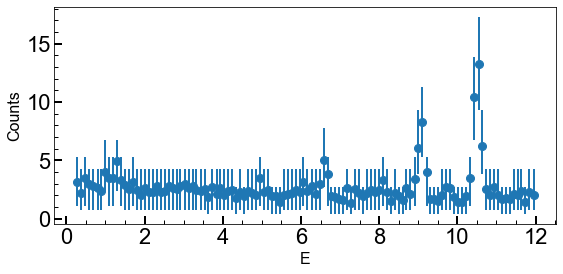

[ 0.2718  0.3775  0.4862  0.5817  0.6832  0.8006  0.8911  0.995   1.0959
  1.2028  1.2905  1.4005  1.5013  1.5972  1.7104  1.8056  1.9066  2.0091
  2.1048  2.2119  2.3088  2.4096  2.5114  2.6242  2.7149  2.8218  2.9184
  3.0256  3.132   3.2339  3.3244  3.4365  3.533   3.623   3.7311  3.8426
  3.9342  4.0403  4.1424  4.2388  4.3448  4.4471  4.5429  4.6503  4.7519
  4.8479  4.9515  5.046   5.1479  5.2541  5.3611  5.462   5.5591  5.6554
  5.7625  5.8698  5.9659  6.0634  6.1638  6.2713  6.3719  6.4748  6.5793
  6.6793  6.7728  6.8796  6.9757  7.0718  7.1802  7.2854  7.3834  7.4791
  7.5857  7.6823  7.7896  7.8963  7.9928  8.101   8.1958  8.3017  8.3988
  8.4948  8.6118  8.6989  8.7945  8.9139  9.0033  9.1027  9.2248  9.3072
  9.4142  9.4994  9.6072  9.7151  9.822   9.9064 10.0235 10.1197 10.2273
 10.3259 10.4319 10.543  10.6292 10.7309 10.8264 10.9344 11.0404 11.136
 11.2325 11.3393 11.4362 11.543  11.6398 11.7346 11.8321 11.9494]


In [2]:
#import data
ge_data = pds.read_csv("CDEX/CDEX_fig6.txt", skiprows=1, \
                         names=['E', 'counts'], \
                         delim_whitespace=False
                     )

ge_data = ge_data.sort_values(by='E')

E = np.asarray(ge_data["E"], dtype=np.float32)
counts = np.asarray(ge_data["counts"], dtype=np.float32)


#asymmetric error bars for low counts
error1 = [0.00,0.37,0.74,1.10,2.34,2.75,3.82,4.25,5.30,6.33,6.78,7.81,8.83,9.28]
error2 = [1.29,2.75,4.25,5.30,6.78,7.81,9.28,10.30,11.32,12.79,13.81,14.82,16.29,17.30]
ntot = counts

ntot_plus = np.zeros(np.shape(ntot))
ntot_minus = np.zeros(np.shape(ntot))
for i,ncount in enumerate(ntot):
    if ncount<=20:
        ntot_plus[i] = error2[int(ncount)]-ncount
        ntot_minus[i] = ncount-error1[int(ncount)]
    else:
        ntot_plus[i] = np.sqrt(ncount)
        ntot_minus[i] = np.sqrt(ncount)


fig,axes = plt.subplots(1,1, figsize=(9,4))

ax1=axes
ax1.errorbar(E, counts, yerr=[ntot_minus,ntot_plus], marker='o', markersize=8, linestyle = 'none')
plt.xlabel("E", fontsize=16)
plt.ylabel("Counts", fontsize=16)
plt.show(fig) 
print(E)

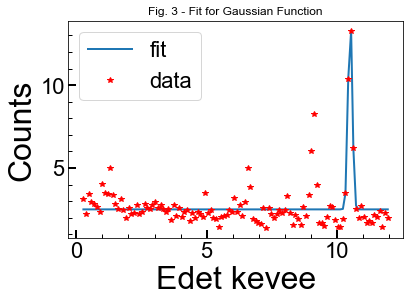

Amplitude :  12.005053801599576  +/-  1.0765876231658926
Mean :  10.50558917919379  +/-  0.006924155136114768
Width/Sigma :  -0.08020394743891818  +/-  0.008068243425928767
Vertical Offset :  2.5106727104016673  +/-  0.08675610908720151


In [3]:
"""def gauss(x, height, stdev, mean):
    return(height*np.exp(-(x-mean)/(2*(stdev**2))))

#Erange=np.linspace(10,11,num=50) 

weight = (1/((ntot_plus+ntot_minus)/2))

f_mod = lm.Model(gauss)
f_params = f_mod.make_params()               # define parameters

f_params.add('amp', vary=True,  value=11.5, min=0)  # half life

# amplitude
f_params.add('sig', vary=True, value=0.25, min=0, max=100)  
# time
f_params.add('c',  vary=True,  value=10.3)

#do the fitting
counts1 = counts/np.sum(counts)
weight1 = weight*np.sum(counts)

fit = f_mod.fit(counts1, params=f_params, x=E, weights=weight1)

fit
elist=list(E)
print(elist)
newe=elist[elist.index(9.9064):elist.index(11.0404)+1]
print(newe)

def gauss(x, height, stdev, mean):
    return height * np.exp(-(x - mean) / (2 * (stdev**2)))

# E is your x-values, counts is your y-values, and weight is the weight for each point
# Make sure these arrays are defined before using them in the fit

weight = 1 / ((ntot_plus + ntot_minus) / 2)

gaussian_mod = lm.Model(gauss)
gaussian_params = gaussian_mod.make_params()

gaussian_params.add('height', vary=True, value=11.5, min=0)
gaussian_params.add('stdev', vary=True, value=0.25, min=0, max=100)
gaussian_params.add('mean', vary=True, value=10.3)

# Perform the fitting
fit_result = gaussian_mod.fit(counts, params=gaussian_params, x=E, weights=weight)

print(fit_result.fit_report())"""

#the following code for fitting gaussians was stolen from Dr. John Carlson 
def gauss_function(x, Amp, Mean, Width, VertOffset):
    return Amp * np.exp(-(x-Mean)**2/(2*Width**2)) + VertOffset
popt, pcov = curve_fit(gauss_function, E, counts, p0 = [11,10.5,0.5,1]) #starting params are (slope, intercept)
plt.plot(E, gauss_function(E, *popt), label='fit')

# plot data

plt.plot(E, counts,'r*', label='data')
perr = np.sqrt(np.diag(pcov)) # print the uncertainties

# Add some axis labels

plt.legend()
plt.title('Gaussian fit for Ge71')
plt.xlabel('Edet kevee')
plt.ylabel('Counts')
plt.show()

print ("Amplitude : ", popt[0], " +/- ", perr[0])
print ("Mean : ", popt[1], " +/- ", perr[1])
print ("Width/Sigma : ", popt[2], " +/- ", perr[2])
print ("Vertical Offset : ", popt[3], " +/- ", perr[3])

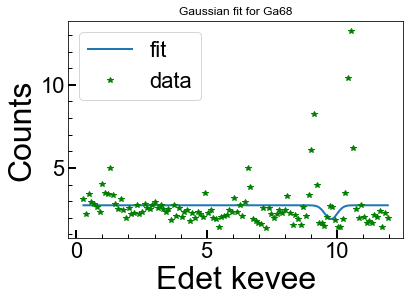

Amplitude :  -0.8438648365166093  +/-  0.9625443884780257
Mean :  9.770504607014114  +/-  0.3074392798854057
Width/Sigma :  0.2342881030857635  +/-  0.3093662349069595
Vertical Offset :  2.755511594855238  +/-  0.15496398398533032


In [13]:
#This fitting method does not seem to work well for smaller peaks like the Gallium 68 one
popt, pcov = curve_fit(gauss_function, E, counts, p0 = [0.85,9.78,0.1,0.0]) #starting params are (slope, intercept)
plt.plot(E, gauss_function(E, *popt), label='fit')

# plot data

plt.plot(E, counts,'g*', label='data')
perr = np.sqrt(np.diag(pcov)) # print the uncertainties

# Add some axis labels

plt.legend()
plt.title('Gaussian fit for Ga68')
plt.xlabel('Edet kevee')
plt.ylabel('Counts')
plt.show()

print ("Amplitude : ", popt[0], " +/- ", perr[0])
print ("Mean : ", popt[1], " +/- ", perr[1])
print ("Width/Sigma : ", popt[2], " +/- ", perr[2])
print ("Vertical Offset : ", popt[3], " +/- ", perr[3])

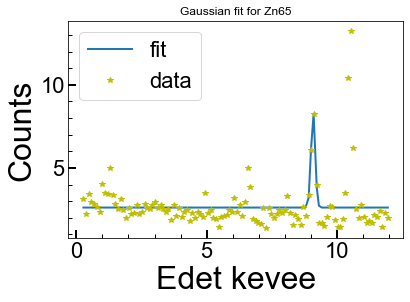

Amplitude :  5.804293391282001  +/-  1.4578076711783452
Mean :  9.083500314148148  +/-  0.026579015009167838
Width/Sigma :  0.07948539619882984  +/-  0.02366811593244281
Vertical Offset :  2.6184681661882028  +/-  0.13765853076734777


In [18]:
popt, pcov = curve_fit(gauss_function, E, counts, p0 = [5.5,9,0.25,0.5]) #starting params are (slope, intercept)
plt.plot(E, gauss_function(E, *popt), label='fit')

# plot data

plt.plot(E, counts,'y*', label='data')
perr = np.sqrt(np.diag(pcov)) # print the uncertainties

# Add some axis labels

plt.legend()
plt.title('Gaussian fit for Zn65')
plt.xlabel('Edet kevee')
plt.ylabel('Counts')
plt.show()

print ("Amplitude : ", popt[0], " +/- ", perr[0])
print ("Mean : ", popt[1], " +/- ", perr[1])
print ("Width/Sigma : ", popt[2], " +/- ", perr[2])
print ("Vertical Offset : ", popt[3], " +/- ", perr[3])